In [1]:
import eryn
from numpy import random
import numpy as np
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt
from eryn.moves import GaussianMove
import corner

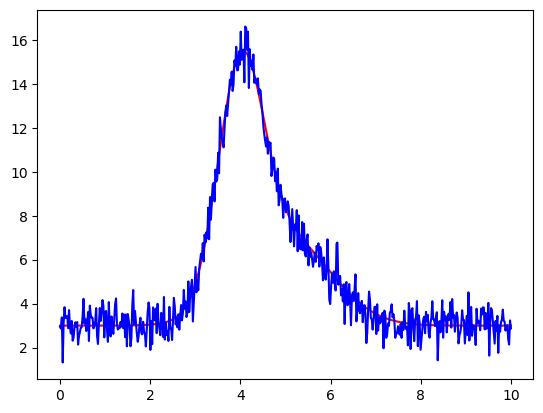

In [2]:

# define gaussian function

def gaussian(t, b, m, s):
    return b*np.exp(-0.5*(t-m)**2/s**2)

# define function to sum the gaussians and add a constant background

def gauss_model(t, a, params):
    function = np.zeros_like(t)
    if params is not None:
        for i in params:
            function = function + gaussian(t, *i)
    function = function + a[0]
    return function

# generate data with noise variance ns and true parameters pars, a

ns = 0.6
pars = [
    [10, 4, 0.5],
    [4, 5, 1]
]
a = [3]

t = np.linspace(0, 10, 500)
signal = gauss_model(t, a, pars)
total = signal + random.normal(0, ns, 500)

# plot true model and data

x = gauss_model(t, a, pars)

plt.plot(t, x, 'r')
plt.plot(t, total, 'b')
plt.show()

In [3]:

# define the log_likelihood function

def log_likelihood(all_params, t, total, ns):
    a, params = all_params
    return -0.5*((total - gauss_model(t, a, params))**2).sum()/ns**2

# branch names and dimensions. Works with nleaves_min=[0,0], doesn't work with nleaves_min=[1,0] .

branch_names = ["constant", "gauss"]

ndim = [1, 3]
nleaves_max = [1, 2]
nwalkers = 100
ntemps = 10

# priors and moves

priors = {
    "constant" : {
        0: uniform_dist(2, 4)
    },
    "gauss" : {
        0: uniform_dist(2, 12),
        1: uniform_dist(2, 8),
        2: uniform_dist(0.2, 2)
    }
}


cov = {
    "constant" : np.identity(ndim[0])*0.01,
    "gauss" : np.identity(ndim[1])*0.01
}

moves = GaussianMove(cov)

# Ensemble. Setting nleaves_min to default still produces error.

ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    log_likelihood,
    priors,
    args = [t, total, ns],
    nbranches = len(branch_names),
    tempering_kwargs= dict(ntemps=ntemps),
    branch_names = branch_names,
    nleaves_max = nleaves_max)

# assign coordinates and inds and save state

coords = {
    name : np.zeros((ntemps, nwalkers, leaves, dims)) for name, leaves, dims in zip(branch_names, nleaves_max, ndim)
}

for name, leaves, dims in zip(branch_names, nleaves_max, ndim):
    for d in range(dims):
        coords[name][:, :, :, d] = priors[name][d].rvs(size=(ntemps, nwalkers, leaves))

#inds = {
#    "constant" : np.ones(shape=(ntemps, nwalkers, nleaves_max[0]), dtype=bool),
#    "gauss" : np.random.randint(low=0, high=2, size=(ntemps, nwalkers, nleaves_max[1]), dtype=bool)
#}

state = State(coords)

In [4]:
coords = {
    name : np.zeros((nwalkers, leaves, dims)) for name, leaves, dims in zip(branch_names, nleaves_max, ndim)
}

for name, leaves, dims in zip(branch_names, nleaves_max, ndim):
    for d in range(dims):
        coords[name][:, :, d] = priors[name][d].rvs(size=(nwalkers, leaves))

coords['gauss'].shape

(100, 2, 3)

In [5]:
# run mcmc

nsteps = 5000

out = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True)

100%|██████████| 5000/5000 [01:13<00:00, 67.74it/s]


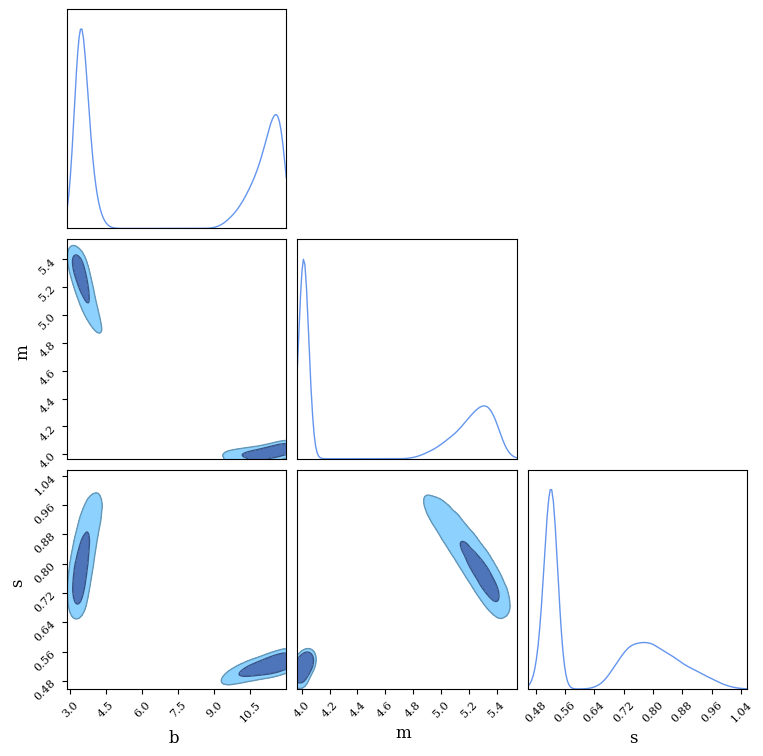

In [6]:
gauss_parameters = ["b", "m", "s"]
constant_parameters = ["a"]

samples_gauss = ensemble.get_chain()['gauss'][:, 0].reshape(-1, ndim[1])
samples_constant = ensemble.get_chain()['constant'][:, 0].reshape(-1, ndim[0])  

c = ChainConsumer()

c.add_chain(samples_gauss, parameters=gauss_parameters, name='gauss', color='#6495ed')
c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8, serif=True)

#for i in pars:
#    c.add_marker([pars[i][0], pars[i][1], pars[i][2]], \
#    parameters=gauss_parameters, marker_style="x", \
#    marker_size=100, color='#DC143C') 

fig = c.plotter.plot(figsize=(8,8), legend=False);

In [8]:
pars

[[10, 4, 0.5], [4, 5, 1]]

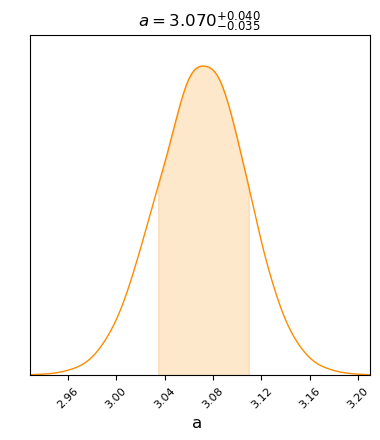

In [7]:
c = ChainConsumer()

c.add_chain(samples_constant, parameters=constant_parameters, name='ct', color='orange')
c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8)

fig = c.plotter.plot(figsize=(4,4), legend=False);